# Importing libraries

In [1]:
# Install tokenizer tool.
!pip install git+https://github.com/erikavaris/tokenizer.git

  Cloning https://github.com/erikavaris/tokenizer.git to /tmp/pip-req-build-xx13naft
  Running command git clone -q https://github.com/erikavaris/tokenizer.git /tmp/pip-req-build-xx13naft
  Created wheel for tokenizer: filename=tokenizer-1.0.1-cp36-none-any.whl size=12978 sha256=07560f4295491284471228998270484b39eb5fe3bff7391dd962a2acaccd77c3
  Stored in directory: /tmp/pip-ephem-wheel-cache-5ok5ujvp/wheels/47/e7/9b/7f3e9b2989a5600b42ffbcc0fd8687562b1738f585f6bd92fa
Successfully built tokenizer


In [2]:
# Import essential libraries.
import os
import gensim
import nltk
nltk.download('stopwords')
import string
import numpy as np
import pandas as pd
from gensim.models.word2vec import Word2Vec
from tokenizer import tokenizer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from nltk.corpus import stopwords
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.preprocessing import sequence
from keras.layers import Dense, Flatten, Dropout, Input, LSTM, RepeatVector, TimeDistributed
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [66]:
# Download the pre-trained GLoVe embeddings.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [86]:
!unzip drive/My\ Drive/glove.twitter.27B.200d.txt.zip

Archive:  drive/My Drive/glove.twitter.27B.200d.txt.zip
replace glove.twitter.27B.200d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.twitter.27B.200d.txt  


# Data processing

In [0]:
# Read the training dataset from the file.
df = pd.read_csv('twitter-train.tsv', sep = '\t', names = ["tweet_id", "label", "tweet"], index_col = 0)
X_train = df.iloc[:, [False, True]]
Y_train = df.loc[:, [True, False]]

In [0]:
# Read the validation dataset from the file.
df = pd.read_csv('twitter-dev.tsv', sep = '\t', names = ["tweet_id", "label", "tweet"], index_col = 0)
X_val = df.iloc[:, [False, True]]
Y_val = df.loc[:, [True, False]]

In [0]:
# Read the test dataset from the file.
df = pd.read_csv('twitter-test.tsv', sep = '\t', names = ["tweet_id", "label", "tweet"], index_col = 0)
X_test = df.iloc[:, [False, True]]
Y_test = df.loc[:, [True, False]]

# Creating word embeddings

In [0]:
# Initialize the tokenizer.
alphabetical = set(string.ascii_lowercase)
T = tokenizer.TweetTokenizer(preserve_handles = False, preserve_hashes = True,
                             preserve_case = False, preserve_url = False,
                             preserve_emoji = False, regularize = True)

In [0]:
# Function for checking the string for alpha-numeric characters.
def alphabetic(x):
    for alpha in x:
        if not alpha.isalnum():
            return False
    
    return True

In [0]:
# Function for processing and cleaning the tweets.
def tweet_tokenize(tweet):
    tweet = tweet.replace('\\u2019', "'")
    tweet = tweet.replace('\\u002c', ',')
    text = T.tokenize(tweet)
    text = filter(lambda x: alphabetic(x), text)
    text = filter(lambda x: x not in ['rt'], text)
    text = filter(lambda x: x not in alphabetical, text)
    tweet = " ".join(text)

    return tweet

In [0]:
# Clean the datasets.
X_train['cleaned_tweet'] = X_train.apply(lambda row: tweet_tokenize(row['tweet']), axis = 1)
X_val['cleaned_tweet'] = X_val.apply(lambda row: tweet_tokenize(row['tweet']), axis = 1)
X_test['cleaned_tweet'] = X_test.apply(lambda row: tweet_tokenize(row['tweet']), axis = 1)

In [10]:
# Initialize the word2vec model.
embedding_dimension = 200
tweet_word2vec = Word2Vec(sentences = [x.split() for x in X_train['cleaned_tweet'].append(X_val['cleaned_tweet'])],
                          size = embedding_dimension, window = 5, workers = 4, min_count = 4, iter = 5)
words = list(tweet_word2vec.wv.vocab)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# Generate the word vectors for the individual tokens in the tweet.
top_words = len(tweet_word2vec.wv.vocab)
max_length = 35

tokenizer = Tokenizer(num_words = top_words)
tokenizer.fit_on_texts([x for x in X_train['cleaned_tweet'].append(X_val['cleaned_tweet'])])
sequences_train = tokenizer.texts_to_sequences([x for x in X_train['cleaned_tweet']])
sequences_test = tokenizer.texts_to_sequences([x for x in X_test['cleaned_tweet']])
sequences_val = tokenizer.texts_to_sequences([x for x in X_val['cleaned_tweet']])

XTrain = sequence.pad_sequences(sequences_train, padding = 'post', maxlen = max_length)
XTest = sequence.pad_sequences(sequences_test, padding = 'post', maxlen = max_length)
XVal = sequence.pad_sequences(sequences_val, padding = 'post', maxlen = max_length)

In [13]:
# Load the GLoVe model.
print("Loading Glove Model")
f = open('glove.twitter.27B.200d.txt', 'r')
gloveModel = {}

for line in f:
    splitLines = line.split()
    word = splitLines[0]
    wordEmbedding = np.array([float(value) for value in splitLines[1 : ]])
    gloveModel[word] = wordEmbedding

print(len(gloveModel)," Words Loaded!")

Loading Glove Model
1193514  Words Loaded!


In [0]:
# Search for suitable word tokens from the input text.
num_words = top_words + 1
embedding_matrix = np.zeros((num_words, embedding_dimension))
count = 0

for i, word in tokenizer.index_word.items():
    if i > top_words:
        break

    embedding_vector = gloveModel.get(word)

    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector.astype(float)
        count += 1

In [0]:
# Function for creating the word vectors to the corresponding input text.
def vectorizer(X):
    vectors = []
    for x in X:
        vector = []
        for i in x:
            vector.append(embedding_matrix[i])
        vectors.append(np.asarray(vector))
    return np.asarray(vectors)

In [0]:
XTrainWV = vectorizer(XTrain)
XValWV = vectorizer(XVal)
XTestWV = vectorizer(XTest)

In [0]:
# Function for labelling the neutral, positive and negative sentiments as integers.
def labeller(x):
    if x == 'neutral':
        return 0
    if x == 'positive':
        return 1
    if x == 'negative':
        return 2

In [18]:
# Process the labels and change to one-hot vectors.
Y_train['label'] = Y_train['label'].apply(lambda x: labeller(x))
YTrain = to_categorical(Y_train['label'].values)
Y_val['label'] = Y_val['label'].apply(lambda x: labeller(x))
YVal = to_categorical(Y_val['label'].values)
Y_test['label'] = Y_test['label'].apply(lambda x: labeller(x))
YTest = to_categorical(Y_test['label'].values)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Creating and Fitting the Models

## We implement three fundamentally different approaches to solving our problem, and provide the results on each approach.

|                      Approach                     |       Accuracy       |
|   ---------------------------------------------   |  ------------------  |
|  1) Separately Trained Autoencoder and Predictor  |        65.15%        |
|  2) Multi-Task Learning Based Autoencoder         |        69.81%        |
|  3) LSTM Autoencoder                              |        68.65%        |

# 1) Separately Trained Autoencoder and Predictor

We train an autoencoder to generate low-dimensional embeddings from the input text, and use these low-dimensional embeddings to predict the sentiment of the input text using a separate FFN-based predictor.

## Autoencoder Network

In [19]:
# Simple Autoencoder Model.
autoencoder = Sequential()
autoencoder.add(Dense(200, input_shape = (max_length, embedding_dimension,), activation = 'tanh'))
autoencoder.add(Dropout(0.2))
autoencoder.add(Dense(100, activation = 'tanh'))
autoencoder.add(Dropout(0.2))
autoencoder.add(Dense(200, activation = 'tanh'))
autoencoder.add(Dropout(0.2))
autoencoder.add(Dense(embedding_dimension, activation = 'tanh'))
autoencoder.compile(loss = 'mse', optimizer = 'adam', metrics = ['accuracy'])
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 35, 200)           40200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 200)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 35, 100)           20100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 35, 100)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 35, 200)           20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 35, 200)           0         
_________________________________________________________________
dense_4 (Dense)              (None, 35, 200)          

## Encoder Network

In [20]:
# Re-use the encoder model from the above autoencoder.
input_text = Input(shape = (max_length, embedding_dimension,))
encoder_layer1 = autoencoder.layers[0]
encoder_layer2 = autoencoder.layers[1]
encoder_layer3 = autoencoder.layers[2]
encoder = Model(input_text, encoder_layer3(encoder_layer2(encoder_layer1(input_text))))
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 35, 200)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 35, 200)           40200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 200)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 35, 100)           20100     
Total params: 60,300
Trainable params: 60,300
Non-trainable params: 0
_________________________________________________________________


In [21]:
autoencoder.fit(XTrainWV, XTrainWV, batch_size = 256, epochs = 20, validation_data = (XValWV, XValWV))

Train on 9684 samples, validate on 1654 samples
Epoch 1/20
9684/9684 [==============================] - 8s 820us/step - loss: 0.1058 - accuracy: 0.1217 - val_loss: 0.0734 - val_accuracy: 0.2095
Epoch 2/20
9684/9684 [==============================] - 8s 796us/step - loss: 0.0786 - accuracy: 0.1828 - val_loss: 0.0656 - val_accuracy: 0.2388
Epoch 3/20
9684/9684 [==============================] - 8s 802us/step - loss: 0.0721 - accuracy: 0.2013 - val_loss: 0.0621 - val_accuracy: 0.2573
Epoch 4/20
9684/9684 [==============================] - 8s 806us/step - loss: 0.0691 - accuracy: 0.2097 - val_loss: 0.0601 - val_accuracy: 0.2557
Epoch 5/20
9684/9684 [==============================] - 8s 810us/step - loss: 0.0673 - accuracy: 0.2143 - val_loss: 0.0589 - val_accuracy: 0.2579
Epoch 6/20
9684/9684 [==============================] - 8s 812us/step - loss: 0.0660 - accuracy: 0.2169 - val_loss: 0.0580 - val_accuracy: 0.2601
Epoch 7/20
9684/9684 [==============================] - 8s 800us/step - loss

In [0]:
# Predict the low-dimensional embeddings through the encoder.
XTrain = encoder.predict(XTrainWV)
XVal = encoder.predict(XValWV)
XTest = encoder.predict(XTestWV)

## Feed-Forward Network Based Prediction

In [23]:
# Simple FFN Model.
predictor = Sequential()
predictor.add(Dense(25, input_shape = (max_length, 100), activation = 'relu'))
predictor.add(Flatten())
predictor.add(Dropout(0.2))
predictor.add(Dense(50, activation = 'relu'))
predictor.add(Dropout(0.2))
predictor.add(Dense(10, activation = 'relu'))
predictor.add(Dropout(0.2))
predictor.add(Dense(3, activation = 'softmax'))
predictor.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
predictor.summary()
predictor.fit(XTrain, YTrain, batch_size = 256, epochs = 20, validation_data = (XVal, YVal))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 35, 25)            2525      
_________________________________________________________________
flatten_1 (Flatten)          (None, 875)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 875)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                43800     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                510       
_________________________________________________________________
dropout_6 (Dropout)          (None, 10)               

In [30]:
# Present the various metrics.
score = predictor.evaluate(XTest, YTest, batch_size = 256, verbose = 1)
print("\nResults for Separately Trained Auto-Encoder and Predictor")
print("Test Loss: %.2f" % (score[0]))
print("Test Accuracy: %.2f%%" % (score[1] * 100))

YPred = predictor.predict_classes(XTest)
print(classification_report(Y_test['label'].values, YPred, target_names = ['Neutral Class', 'Positive Class', 'Negative Class']))

3547/3547 [==============================] - 0s 16us/step

Results for Separately Trained Auto-Encoder and Predictor
Test Loss: 0.79
Test Accuracy: 65.15%
                precision    recall  f1-score   support

 Neutral Class       0.59      0.85      0.70      1513
Positive Class       0.77      0.56      0.65      1475
Negative Class       0.64      0.36      0.46       559

      accuracy                           0.65      3547
     macro avg       0.67      0.59      0.60      3547
  weighted avg       0.67      0.65      0.64      3547



[[1288  172   53]
 [ 595  822   58]
 [ 283   75  201]]


[Text(0, 0.5, 'Neutral'), Text(0, 1.5, 'Positive'), Text(0, 2.5, 'Negative')]

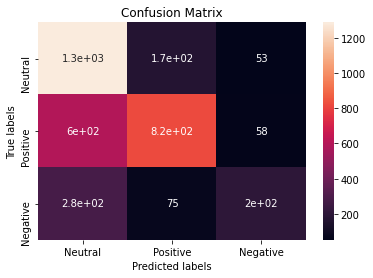

In [27]:
# Plot the confusion matrix per class.
cm = confusion_matrix(Y_test['label'].values, YPred, labels = [0, 1, 2])
print(cm)
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Neutral', 'Positive', 'Negative'])
ax.yaxis.set_ticklabels(['Neutral', 'Positive', 'Negative'])

# 2) Multi Task Learning Approach

We train an autoencoder and predictor using a multi-task learning based approach where after passing the input through a common encoder, the low-dimensional output embeddings are passed to the reconstructive decoder along one task, and used to predict the sentiment along the other task.

In [28]:
# Simple Multi-Task Autoencoder Model.
input_text = Input(shape = (max_length, embedding_dimension,))
enc1 = Dense(200, activation = 'tanh')(input_text)
enc1 = Dropout(0.2)(enc1)
enc2 = Dense(100, activation = 'tanh')(enc1)
enc2 = Dropout(0.2)(enc2)

dec1 = Dense(200, activation = 'tanh')(enc2)
dec1 = Dropout(0.2)(dec1)
dec2 = Dense(embedding_dimension, activation = 'tanh')(dec1)

pred1 = Dense(25, activation = 'relu')(enc2)
pred1 = Flatten()(pred1)
pred1 = Dropout(0.2)(pred1)
pred2 = Dense(50, activation = 'relu')(pred1)
pred2 = Dropout(0.2)(pred2)
pred3 = Dense(10, activation = 'relu')(pred2)
pred3 = Dropout(0.2)(pred3)
pred4 = Dense(3, activation = 'softmax')(pred3)

multi_autoencoder = Model(inputs = input_text, outputs = [dec2, pred4])
multi_autoencoder.compile(loss = ['mse', 'categorical_crossentropy'], optimizer = 'adam', metrics = ['accuracy'])
multi_autoencoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 35, 200)      0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 35, 200)      40200       input_2[0][0]                    
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 35, 200)      0           dense_9[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 35, 100)      20100       dropout_7[0][0]                  
____________________________________________________________________________________________

In [29]:
# Train the model on the word vectors.
multi_autoencoder.fit(XTrainWV, [XTrainWV, YTrain], batch_size = 256, epochs = 10, validation_data = (XValWV, [XValWV, YVal]))

Train on 9684 samples, validate on 1654 samples
Epoch 1/10
9684/9684 [==============================] - 9s 880us/step - loss: 1.1522 - dense_12_loss: 0.1173 - dense_16_loss: 1.0346 - dense_12_accuracy: 0.1193 - dense_16_accuracy: 0.4526 - val_loss: 1.1187 - val_dense_12_loss: 0.0824 - val_dense_16_loss: 1.0349 - val_dense_12_accuracy: 0.1921 - val_dense_16_accuracy: 0.4728
Epoch 2/10
9684/9684 [==============================] - 8s 835us/step - loss: 1.0718 - dense_12_loss: 0.0891 - dense_16_loss: 0.9826 - dense_12_accuracy: 0.1637 - dense_16_accuracy: 0.4952 - val_loss: 1.0691 - val_dense_12_loss: 0.0741 - val_dense_16_loss: 0.9931 - val_dense_12_accuracy: 0.2277 - val_dense_16_accuracy: 0.5006
Epoch 3/10
9684/9684 [==============================] - 8s 838us/step - loss: 1.0139 - dense_12_loss: 0.0813 - dense_16_loss: 0.9331 - dense_12_accuracy: 0.1812 - dense_16_accuracy: 0.5390 - val_loss: 0.9998 - val_dense_12_loss: 0.0712 - val_dense_16_loss: 0.9257 - val_dense_12_accuracy: 0.2339 

In [40]:
# Present the various metrics.
score = multi_autoencoder.evaluate(XTestWV, [XTestWV, YTest], batch_size = 256, verbose = 1)
print("\nResults for Multi-Task Learning Approach")
print("Test Loss: %.2f" % (score[2]))
print("Test Accuracy: %.2f%%" % (score[4] * 100))

YPred = multi_autoencoder.predict(XTestWV)
YPred = YPred[1].argmax(axis = 1)
print(classification_report(Y_test['label'].values, YPred, target_names = ['Neutral Class', 'Positive Class', 'Negative Class']))

3547/3547 [==============================] - 1s 269us/step

Results for Multi-Task Learning Approach
Test Loss: 0.71
Test Accuracy: 69.81%
                precision    recall  f1-score   support

 Neutral Class       0.67      0.80      0.73      1513
Positive Class       0.78      0.65      0.71      1475
Negative Class       0.62      0.55      0.58       559

      accuracy                           0.70      3547
     macro avg       0.69      0.67      0.67      3547
  weighted avg       0.70      0.70      0.70      3547



[[1206  208   99]
 [ 420  963   92]
 [ 181   71  307]]


[Text(0, 0.5, 'Neutral'), Text(0, 1.5, 'Positive'), Text(0, 2.5, 'Negative')]

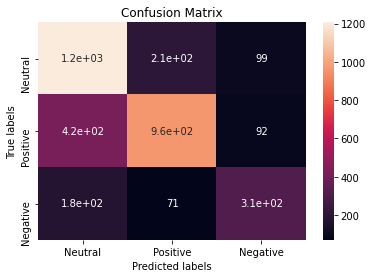

In [41]:
# Plot the confusion matrix per class.
cm = confusion_matrix(Y_test['label'].values, YPred, labels = [0, 1, 2])
print(cm)
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Neutral', 'Positive', 'Negative'])
ax.yaxis.set_ticklabels(['Neutral', 'Positive', 'Negative'])

# 3) LSTM AutoEncoder

We model the previously used multi-task learning based approach, and use an LSTM to encode the input text sequences. After passing the input through a common encoder, the low-dimensional output embeddings are passed to the reconstructive decoder along one task, and used to predict the sentiment along the other task.

In [42]:
# Simple LSTM-based Encoder
input_text = Input(shape = (max_length, embedding_dimension,))
encoder = LSTM(200, activation = 'tanh')(input_text)
# Simple LSTM-based Reconstruction Decoder
decoder1 = RepeatVector(max_length)(encoder)
decoder1 = LSTM(200, activation = 'tanh', return_sequences = True)(decoder1)
decoder1 = TimeDistributed(Dense(embedding_dimension))(decoder1)
# Simple LSTM-based Prediction Decoder
decoder2 = RepeatVector(max_length)(encoder)
decoder2 = LSTM(100, activation = 'relu', return_sequences = False)(decoder2)
decoder2 = Dropout(0.2)(decoder2)
decoder2 = Dense(50, activation = 'relu')(decoder2)
decoder2 = Dropout(0.2)(decoder2)
decoder2 = Dense(3, activation = 'softmax')(decoder2)

lstm_autoencoder = Model(inputs = input_text, outputs = [decoder1, decoder2])
lstm_autoencoder.compile(loss = ['mse', 'categorical_crossentropy'], optimizer = 'adam', metrics = ['accuracy'])
lstm_autoencoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 35, 200)      0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 200)          320800      input_3[0][0]                    
__________________________________________________________________________________________________
repeat_vector_2 (RepeatVector)  (None, 35, 200)      0           lstm_1[0][0]                     
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 100)          120400      repeat_vector_2[0][0]            
____________________________________________________________________________________________

In [43]:
# Train the model on the word vectors.
lstm_autoencoder.fit(XTrainWV, [XTrainWV, YTrain], batch_size = 256, epochs = 8, validation_data = (XValWV, [XValWV, YVal]))

Train on 9684 samples, validate on 1654 samples
Epoch 1/8
9684/9684 [==============================] - 49s 5ms/step - loss: 1.1028 - time_distributed_1_loss: 0.0897 - dense_19_loss: 1.0128 - time_distributed_1_accuracy: 0.1212 - dense_19_accuracy: 0.4588 - val_loss: 1.0744 - val_time_distributed_1_loss: 0.0707 - val_dense_19_loss: 1.0006 - val_time_distributed_1_accuracy: 0.1898 - val_dense_19_accuracy: 0.4607
Epoch 2/8
9684/9684 [==============================] - 47s 5ms/step - loss: 0.9813 - time_distributed_1_loss: 0.0762 - dense_19_loss: 0.9045 - time_distributed_1_accuracy: 0.1763 - dense_19_accuracy: 0.5741 - val_loss: 0.9788 - val_time_distributed_1_loss: 0.0848 - val_dense_19_loss: 0.8858 - val_time_distributed_1_accuracy: 0.1818 - val_dense_19_accuracy: 0.6167
Epoch 3/8
9684/9684 [==============================] - 48s 5ms/step - loss: 0.8778 - time_distributed_1_loss: 0.0713 - dense_19_loss: 0.8069 - time_distributed_1_accuracy: 0.1822 - dense_19_accuracy: 0.6526 - val_loss: 0

In [44]:
# Present the various metrics.
score = lstm_autoencoder.evaluate(XTestWV, [XTestWV, YTest], batch_size = 256, verbose = 1)
print("\nResults for LSTM Auto-Encoder Approach")
print("Test Loss: %.2f" % (score[2]))
print("Test Accuracy: %.2f%%" % (score[4] * 100))

YPred = lstm_autoencoder.predict(XTestWV)
YPred = YPred[1].argmax(axis = 1)
print(classification_report(Y_test['label'].values, YPred, target_names = ['Neutral Class', 'Positive Class', 'Negative Class']))

3547/3547 [==============================] - 5s 1ms/step

Results for LSTM Auto-Encoder Approach
Test Loss: 0.72
Test Accuracy: 68.59%
                precision    recall  f1-score   support

 Neutral Class       0.68      0.73      0.70      1513
Positive Class       0.70      0.70      0.70      1475
Negative Class       0.65      0.53      0.58       559

      accuracy                           0.69      3547
     macro avg       0.68      0.65      0.66      3547
  weighted avg       0.69      0.69      0.68      3547



[[1101  317   95]
 [ 376 1037   62]
 [ 145  119  295]]


[Text(0, 0.5, 'Neutral'), Text(0, 1.5, 'Positive'), Text(0, 2.5, 'Negative')]

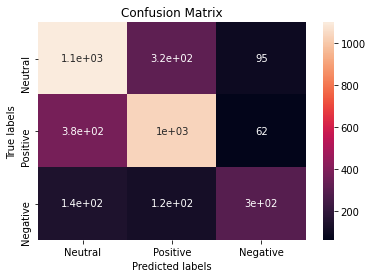

In [45]:
# Plot the confusion matrix per class.
cm = confusion_matrix(Y_test['label'].values, YPred, labels = [0, 1, 2])
print(cm)
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Neutral', 'Positive', 'Negative'])
ax.yaxis.set_ticklabels(['Neutral', 'Positive', 'Negative'])